# Painting Crack Detection using CNN Model
This model will trying to detect a crack in painting. CNN can work with detection and classification, the detected painting will classified to 2 class : Crack and NonCrack. Hence, the dataset also consist 2 label : Crack and NonCrack.

In [ ]:
# Unzip File Dataset
import zipfile

local_zip = '/content/PaintingDataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

## Extract the Dataset

In [ ]:
from google.colab import drive
import zipfile

drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/PaintingDataset.zip'


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data')  


Mounted at /content/drive


In [ ]:
import os

base_dir = '/content/data/Painting Dataset'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/Training'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/Validation'))

Contents of base directory:
['Validation', 'Training']

Contents of train directory:
['Crack', 'NonCrack']

Contents of validation directory:
['Crack', 'NonCrack']


In [ ]:
import os

train_dir = os.path.join(base_dir, 'Training')
validation_dir = os.path.join(base_dir, 'Validation')

# Directory with training crack and noncrack images pictures
train_noncrack_dir = os.path.join(train_dir, 'NonCrack')
train_crack_dir = os.path.join(train_dir, 'Crack')

# Directory with validation crack and noncrack images pictures
validation_noncrack_dir = os.path.join(validation_dir, 'NonCrack')
validation_crack_dir = os.path.join(validation_dir, 'Crack')

In [ ]:
train_noncrack_fnames = os.listdir( train_noncrack_dir )
train_crack_fnames = os.listdir( train_crack_dir )

print("Non Crack Painting : ", train_noncrack_fnames[:10])
print("Crack Painting : ", train_crack_fnames[:10])

Non Crack Painting :  ['0043.jpg', '0344.jpg', '0264.jpg', '0060.jpg', '0272.jpg', '0195.jpg', '0174.jpg', '0310.jpg', '0230.jpg', '0037.jpg']
Crack Painting :  ['1monali3.jpg', '5peter5.jpg', '4deposit.jpg', '5miracle.jpg', '44betrot.jpg', '37entom0.jpg', 'griseld3.jpg', '1south5.jpg', '1south4.jpg', '04portma.jpg']


In [ ]:
print('total training NonCrack images :', len(os.listdir(      train_noncrack_dir ) ))
print('total training Crack images :', len(os.listdir(      train_crack_dir ) ))

print('total validation NonCrack images :', len(os.listdir( validation_noncrack_dir ) ))
print('total validation Crack images :', len(os.listdir( validation_crack_dir ) ))

total training NonCrack images : 240
total training Crack images : 240
total validation NonCrack images : 60
total validation Crack images : 60


## Display & Check the Dataset

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt


nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

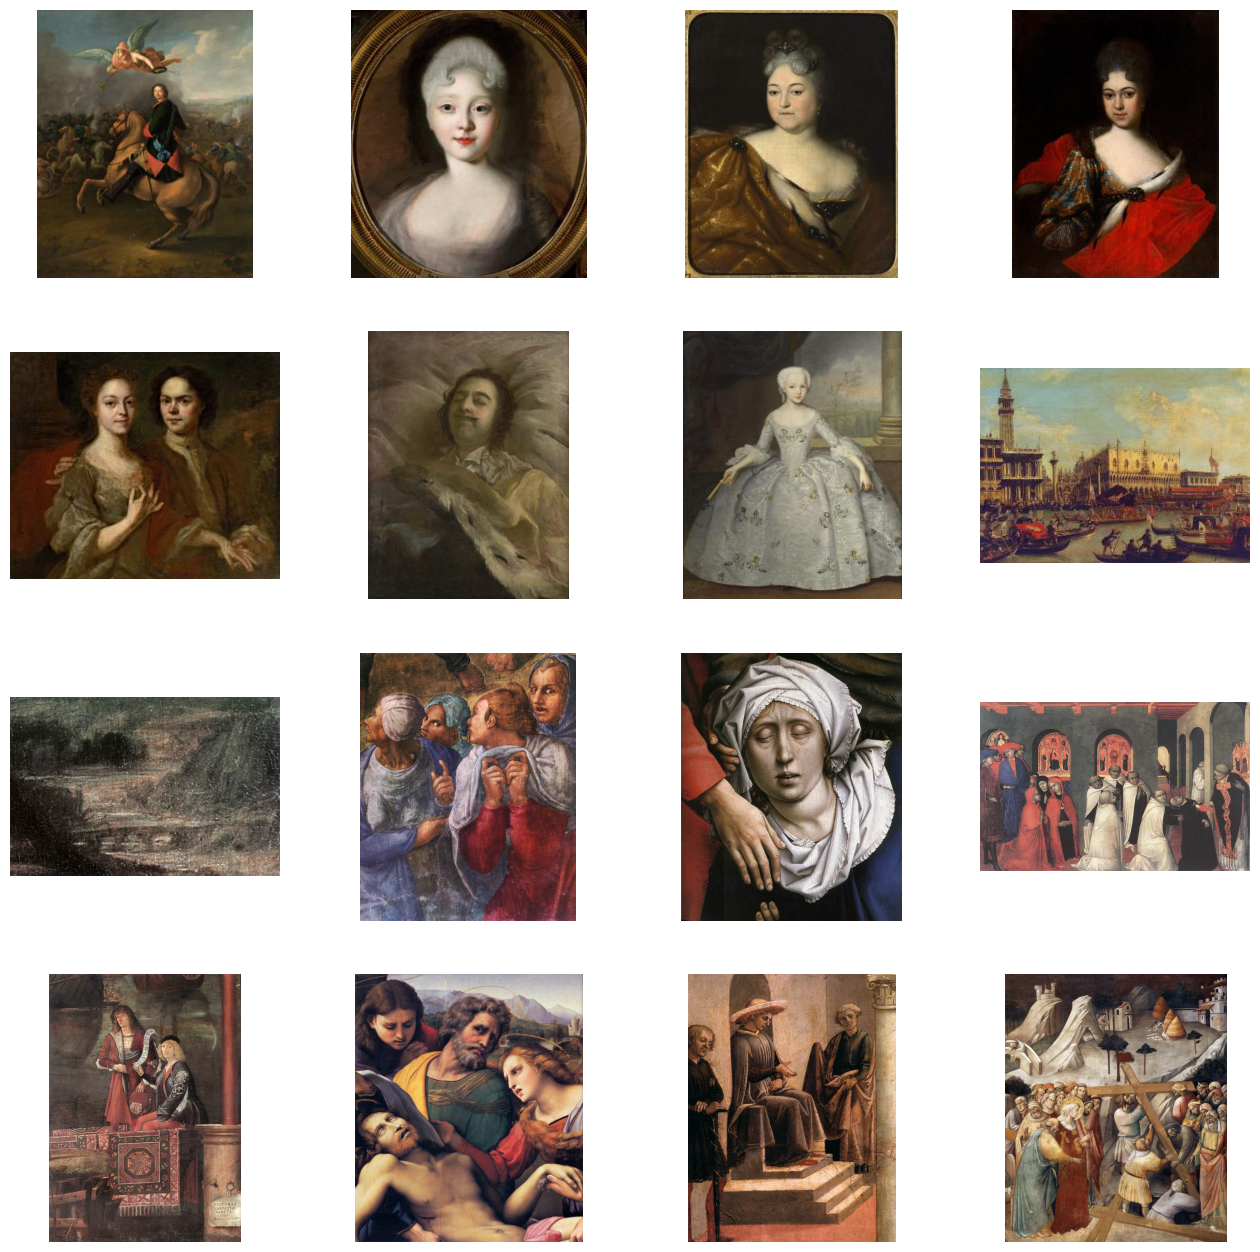

In [ ]:

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_noncrack_pix = [os.path.join(train_noncrack_dir, fname) 
                for fname in train_noncrack_fnames[ pic_index-8:pic_index] 
               ]

next_crack_pix = [os.path.join(train_crack_dir, fname) 
                for fname in train_crack_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_noncrack_pix+next_crack_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Data Processing / Preprocessing Data

In [ ]:
# Data Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rescale 1/255
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the custom preprocessing function
def custom_preprocessing(img):
    # Define the kernel size for the top-hat transform
    kernel_size = 10
    # Define the structuring element for the top-hat transform
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    # Perform the top-hat transform to enhance the contrast of the cracks
    tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
    # Define the kernel size for the dilation operation
    kernel_size = 3
    # Define the structuring element for the dilation operation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    # Perform the dilation operation to expand the boundaries of the cracks
    dilated = cv2.dilate(tophat, kernel)
    # Return the preprocessed image
    return dilated

# Define the data generators for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=custom_preprocessing
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=custom_preprocessing
)

# Load the training and validation data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(250, 250),
    batch_size=20,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(250, 250),
    batch_size=20,
    class_mode='binary'
)


# The Model

In [ ]:
# Model
import tensorflow as tf

model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('noncrack') and 1 for the other ('crack')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
!pip install tensorflow-addons==0.16.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.2 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow_addons as tfa

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tfa.metrics.F1Score(1)])

In [ ]:
history = model.fit(
            train_generator,
            epochs=15,
            validation_data=validation_generator,
            verbose=1
            )

Epoch 1/15
24/24 [==============================] - 17s 220ms/step - loss: 0.7493 - accuracy: 0.6167 - val_loss: 0.6166 - val_accuracy: 0.6583
Epoch 2/15
24/24 [==============================] - 7s 270ms/step - loss: 0.3899 - accuracy: 0.8417 - val_loss: 0.4069 - val_accuracy: 0.7583
Epoch 3/15
24/24 [==============================] - 5s 204ms/step - loss: 0.2061 - accuracy: 0.9167 - val_loss: 0.0904 - val_accuracy: 0.9667
Epoch 4/15
24/24 [==============================] - 7s 309ms/step - loss: 0.1350 - accuracy: 0.9438 - val_loss: 0.6269 - val_accuracy: 0.7333
Epoch 5/15
24/24 [==============================] - 5s 210ms/step - loss: 0.0953 - accuracy: 0.9708 - val_loss: 0.0818 - val_accuracy: 0.9833
Epoch 6/15
24/24 [==============================] - 6s 232ms/step - loss: 0.1433 - accuracy: 0.9500 - val_loss: 0.1138 - val_accuracy: 0.9500
Epoch 7/15
24/24 [==============================] - 6s 247ms/step - loss: 0.0934 - accuracy: 0.9708 - val_loss: 0.1039 - val_accuracy: 0.9500
Epoch

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

In [ ]:
# Evaluate metrics

# Evaluate the model on the validation set
val_loss, val_recall, val_false_pos, val_false_neg, val_precision, val_f1_score = model.evaluate(validation_generator, steps=len(validation_generator))

# Print the evaluation metrics
print('Validation loss: {:.3f}'.format(val_loss))
print('Validation recall: {:.3f}'.format(val_recall))
print('Validation false positive rate: {:.3f}'.format(val_false_pos))
print('Validation false negative rate: {:.3f}'.format(val_false_neg))
print('Validation precision: {:.3f}'.format(val_precision))
print('Validation F1 score: {:.3f}'.format(val_f1_score[0]))

# Predict on the validation set and generate a classification report
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_true, y_pred))

In [ ]:
# Prediksi lukisan memiliki retakan atau tidak.
## Pinpoint untuk tahap selanjutnya dalam melakukan patching pada lukisan retak
import numpy as np
import matplotlib.pyplot as plt
import os

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array


if not os.path.exists('inputs/upload'):
    os.makedirs('inputs/upload')

uploaded = files.upload()

for fn in uploaded.keys():
  
  # Load and display the image
  img = load_img('/content/' + fn, target_size=(150, 150))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  # Predict the class label
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  # Print the prediction result
  if classes[0] > 0.5:
    print(fn + " is a non-crack")
  else:
    print(fn + " is a crack")

  save_path = os.path.join('inputs/upload', fn)
  img.save(save_path)


Text(0.5, 1.0, 'Training and validation loss')

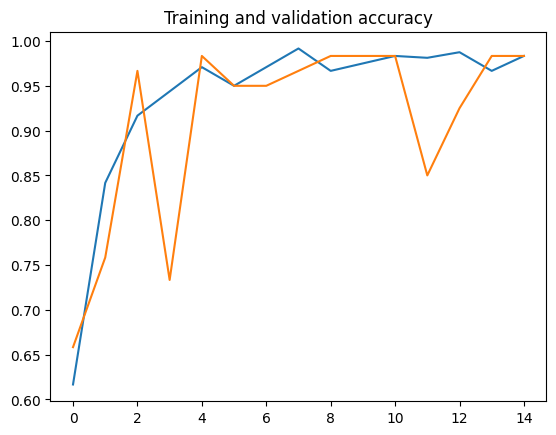

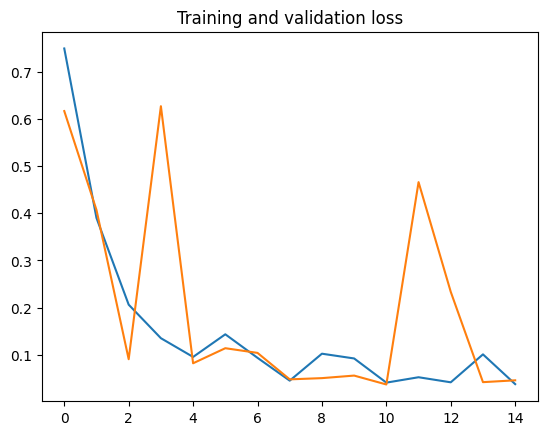

In [ ]:

acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) 

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [ ]:
model.save('my_model.h5')

# Next Step : Still in Experimental. (Restoration using CNN GANs and the library)

Proses restorasi menggunakan library dan inference dari Tencent Restoration Project dibawah lisensi Apache License Version 2.0 (For Non-Comercial Only). 

Selain itu, digunakan pretrained model dalam proses restorasi:
- Pre-trained StyleGAN2 model: StyleGAN2_512_Cmul1_FFHQ_B12G4_scratch_800k.pth :
https://github.com/TencentARC/GFPGAN/releases/download/v0.1.0/StyleGAN2_512_Cmul1_FFHQ_B12G4_scratch_800k.pth
- Component locations of FFHQ: FFHQ_eye_mouth_landmarks_512.pth :
https://github.com/TencentARC/GFPGAN/releases/download/v0.1.0/FFHQ_eye_mouth_landmarks_512.pth
- A simple ArcFace model: arcface_resnet18.pth :
https://github.com/TencentARC/GFPGAN/releases/download/v0.1.0/arcface_resnet18.pth

In [ ]:
%cd /content
!rm -rf GFPGAN
!git clone https://github.com/TencentARC/GFPGAN.git
%cd GFPGAN

!pip install basicsr
!pip install facexlib
!pip install -r requirements.txt
!python setup.py develop
!pip install realesrgan
!wget https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth -P experiments/pretrained_models

/content
Cloning into 'GFPGAN'...
remote: Enumerating objects: 523, done.
remote: Total 523 (delta 0), reused 0 (delta 0), pack-reused 523
Receiving objects: 100% (523/523), 5.39 MiB | 4.53 MiB/s, done.
Resolving deltas: 100% (264/264), done.
/content/GFPGAN
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 102.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 24.4 MB/s eta 0:00:00
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214823 sha256=d83fc6e41a9f06ce1b2f5ba14283296aa8117184aa3dff17b6a05acf9f4d7400
  Stored in directory: /root/.cache/pip/wheels/38/83/99/2d8437cc652a01af27df5ff037a4075e95b52d67705c5f30ca
Successfully built

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 26.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110459 sha256=e554ce17bdd5fe241f76bb19112c7a3a078d07775666a8e555f1b2d089aebdb5
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
     

In [ ]:
# upload 
import os
from google.colab import files
import shutil

upload_folder = 'inputs/upload'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
os.mkdir(upload_folder)

# upload 
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

Saving 10woman1.jpg to 10woman1.jpg
move 10woman1.jpg to inputs/upload/10woman1.jpg


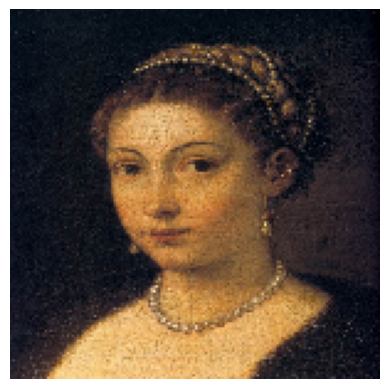

1/1 [==============================] - 0s 22ms/step
10woman1.jpg is a crack


In [ ]:
# Prediksi lukisan memiliki retakan atau tidak.
## Pinpoint untuk tahap selanjutnya dalam melakukan patching pada lukisan retak
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

folder_path = '/content/GFPGAN/inputs/upload'  # Folder berisi gambar lukisan


image_files = os.listdir(folder_path)

for filename in image_files:
   
    image_path = os.path.join(folder_path, filename)
    
    # Load and display the image
    img = load_img(image_path, target_size=(150, 150))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Predict the class label
    x = img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)

    # Print the prediction result
    if classes[0] > 0.5:
        print(filename + " is a non-crack")
    else:
        print(filename + " is a crack")


## Setting Training dari Library

In [ ]:
# Training Config

name: train_GFPGANv1_512
model_type: GFPGANModel
num_gpu: auto  
manual_seed: 0

# dataset and data loader settings
datasets:
  train:
    name: FFHQ
    type: FFHQDegradationDataset
    # dataroot_gt: datasets/ffhq/ffhq_512.lmdb
    dataroot_gt: datasets/ffhq/ffhq_512
    io_backend:
      # type: lmdb
      type: disk

    use_hflip: true
    mean: [0.5, 0.5, 0.5]
    std: [0.5, 0.5, 0.5]
    out_size: 512

    blur_kernel_size: 41
    kernel_list: ['iso', 'aniso']
    kernel_prob: [0.5, 0.5]
    blur_sigma: [0.1, 10]
    downsample_range: [0.8, 8]
    noise_range: [0, 20]
    jpeg_range: [60, 100]

    # color jitter and gray
    color_jitter_prob: 0.3
    color_jitter_shift: 20
    color_jitter_pt_prob: 0.3
    gray_prob: 0.01

    crop_components: true
    component_path: experiments/pretrained_models/FFHQ_eye_mouth_landmarks_512.pth
    eye_enlarge_ratio: 1.4

    # data loader
    use_shuffle: true
    num_worker_per_gpu: 6
    batch_size_per_gpu: 3
    dataset_enlarge_ratio: 1
    prefetch_mode: ~

  val:
    type: PairedImageDataset
    dataroot_lq: datasets/faces/validation/input
    dataroot_gt: datasets/faces/validation/reference
    io_backend:
      type: disk
    mean: [0.5, 0.5, 0.5]
    std: [0.5, 0.5, 0.5]
    scale: 1

# network structures
network_g:
  type: GFPGANv1
  out_size: 512
  num_style_feat: 512
  channel_multiplier: 1
  resample_kernel: [1, 3, 3, 1]
  decoder_load_path: experiments/pretrained_models/StyleGAN2_512_Cmul1_FFHQ_B12G4_scratch_800k.pth
  fix_decoder: true
  num_mlp: 8
  lr_mlp: 0.01
  input_is_latent: true
  different_w: true
  narrow: 1
  sft_half: true

network_d:
  type: StyleGAN2Discriminator
  out_size: 512
  channel_multiplier: 1
  resample_kernel: [1, 3, 3, 1]

network_d_left_eye:
  type: FacialComponentDiscriminator

network_d_right_eye:
  type: FacialComponentDiscriminator

network_d_mouth:
  type: FacialComponentDiscriminator

network_identity:
  type: ResNetArcFace
  block: IRBlock
  layers: [2, 2, 2, 2]
  use_se: False

# path
path:
  pretrain_network_g: ~
  param_key_g: params_ema
  strict_load_g: ~
  pretrain_network_d: ~
  pretrain_network_d_left_eye: ~
  pretrain_network_d_right_eye: ~
  pretrain_network_d_mouth: ~
  pretrain_network_identity: experiments/pretrained_models/arcface_resnet18.pth
  # resume
  resume_state: ~
  ignore_resume_networks: ['network_identity']

# training settings
train:
  optim_g:
    type: Adam
    lr: !!float 2e-3
  optim_d:
    type: Adam
    lr: !!float 2e-3
  optim_component:
    type: Adam
    lr: !!float 2e-3

  scheduler:
    type: MultiStepLR
    milestones: [600000, 700000]
    gamma: 0.5

  total_iter: 800000
  warmup_iter: -1  # no warm up

  # losses
  # pixel loss
  pixel_opt:
    type: L1Loss
    loss_weight: !!float 1e-1
    reduction: mean
  # L1 loss used in pyramid loss, component style loss and identity loss
  L1_opt:
    type: L1Loss
    loss_weight: 1
    reduction: mean

  # image pyramid loss
  pyramid_loss_weight: 1
  remove_pyramid_loss: 50000
  # perceptual loss (content and style losses)
  perceptual_opt:
    type: PerceptualLoss
    layer_weights:
      # before relu
      'conv1_2': 0.1
      'conv2_2': 0.1
      'conv3_4': 1
      'conv4_4': 1
      'conv5_4': 1
    vgg_type: vgg19
    use_input_norm: true
    perceptual_weight: !!float 1
    style_weight: 50
    range_norm: true
    criterion: l1
  # gan loss
  gan_opt:
    type: GANLoss
    gan_type: wgan_softplus
    loss_weight: !!float 1e-1
  # r1 regularization for discriminator
  r1_reg_weight: 10
  # facial component loss
  gan_component_opt:
    type: GANLoss
    gan_type: vanilla
    real_label_val: 1.0
    fake_label_val: 0.0
    loss_weight: !!float 1
  comp_style_weight: 200
  # identity loss
  identity_weight: 10

  net_d_iters: 1
  net_d_init_iters: 0
  net_d_reg_every: 16

# validation settings
val:
  val_freq: !!float 5e3
  save_img: true

  metrics:
    psnr: # metric name
      type: calculate_psnr
      crop_border: 0
      test_y_channel: false

# logging settings
logger:
  print_freq: 100
  save_checkpoint_freq: !!float 5e3
  use_tb_logger: true
  wandb:
    project: ~
    resume_id: ~

# dist training settings
dist_params:
  backend: nccl
  port: 29500

find_unused_parameters: true

In [ ]:
!rm -rf results
!python inference_gfpgan.py -i inputs/upload -o results -v 1.3 -s 2 --bg_upsampler realesrgan

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Processing 10woman1.jpg ...
	Tile 1/9
	Tile 2/9
	Tile 3/9
	Tile 4/9
	Tile 5/9
	Tile 6/9
	Tile 7/9
	Tile 8/9
	Tile 9/9
Results 

## Output Image

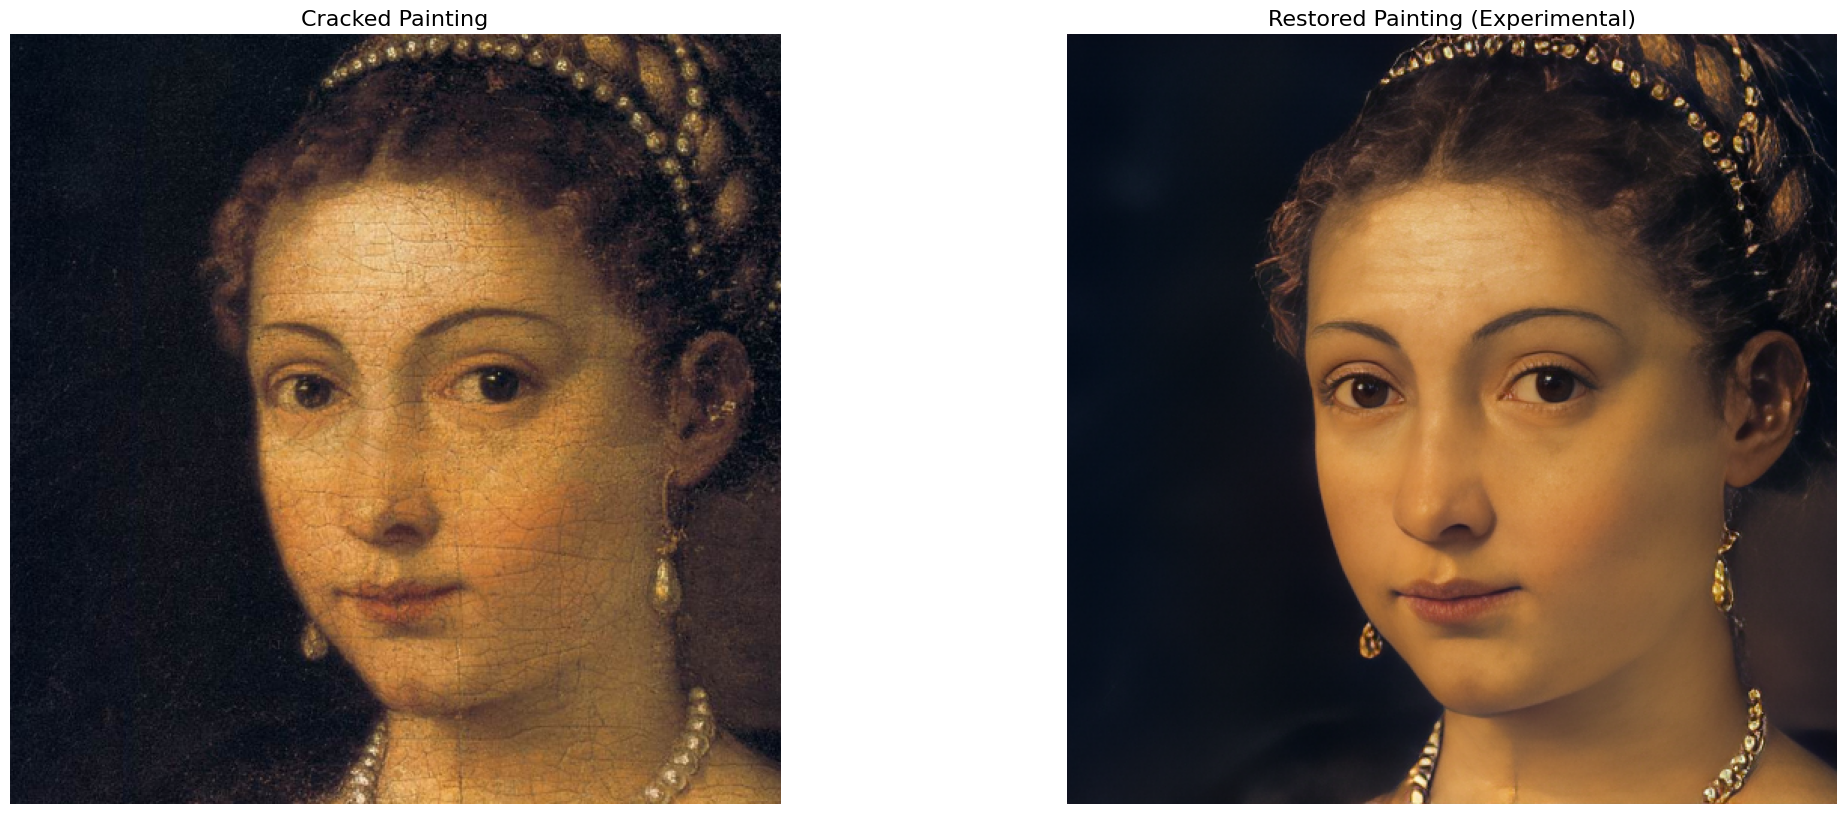

In [ ]:
import cv2
import matplotlib.pyplot as plt
def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1) 
  plt.title('Cracked Painting', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('Restored Painting (Experimental)', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)
def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# display each image in the upload folder
import os
import glob

input_folder = 'results/cropped_faces'
result_folder = 'results/restored_faces'
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
for input_path, output_path in zip(input_list, output_list):
  img_input = imread(input_path)
  img_output = imread(output_path)
  display(img_input, img_output)